In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import SGD


# ESTUDO IMPORTANTES PARAR ESTUDAR
https://www.datacamp.com/tutorial/lstm-python-stock-market
https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/

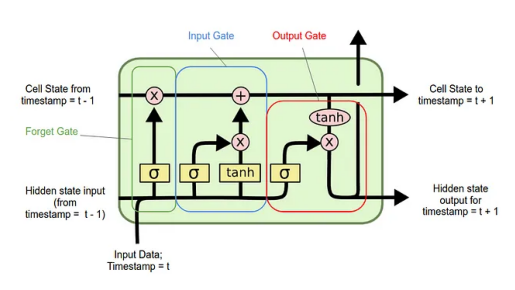

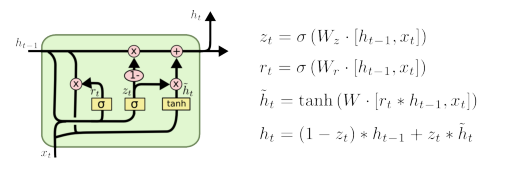

In [2]:
import matplotlib.image as img

imagem = img.imread('lstm.webp')
plt.imshow(imagem)
plt.axis('off')
plt.show()

imagem = img.imread('LSTM3-var-GRU.png')
plt.imshow(imagem)
plt.axis('off')
plt.show()

# CARREGANDO DADOS

In [3]:
dados = pd.read_csv("PETR4.SA_maior.csv")
dados.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,5.875,5.875,5.875,5.875,1.549026,3.538944e+10
1,2000-01-04,5.550,5.550,5.550,5.550,1.463335,2.886144e+10
2,2000-01-05,5.494,5.494,5.494,5.494,1.448570,4.303360e+10
3,2000-01-06,5.475,5.475,5.475,5.475,1.443560,3.405568e+10
4,2000-01-07,5.500,5.500,5.500,5.500,1.450152,2.091264e+10


# TRATAMENTO DOS DADOS NULOS

In [6]:
dados[dados.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
1261,2004-11-02,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dados = dados.dropna()
dados[dados.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume


# Visualização dos Dados

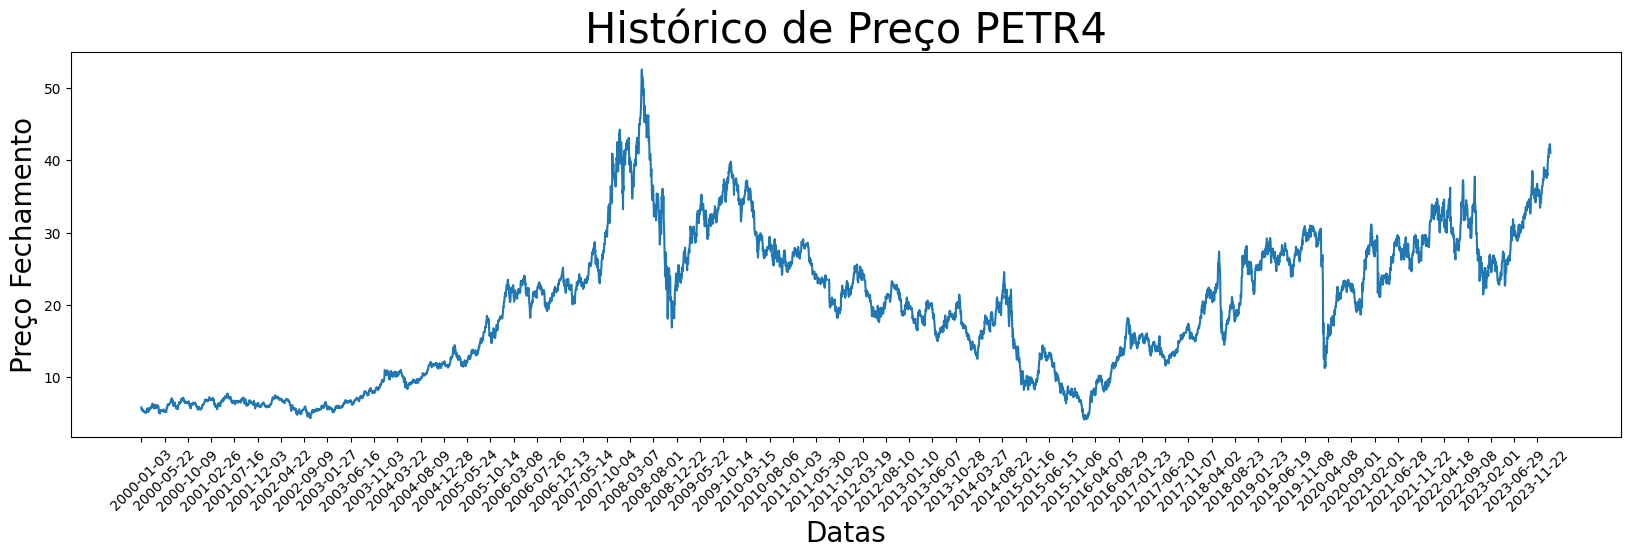

In [10]:
plt.figure(figsize = (20,5))

plt.plot(dados['Close'])
plt.xticks(range(0,dados.shape[0], 100), dados['Date'].loc[::100], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Fechamento', fontsize=20)
plt.title("Histórico de Preço PETR4", fontsize=30)

plt.show()

In [9]:
days_time_step = 15
precos = dados['Close']

# SEPARANDO TREINO E TESTE

In [11]:
size_treino = int(len(precos) * 0.90)
size_teste = len(precos) - size_treino

dados_treino, input_data = np.array(precos[0:size_treino]), np.array(precos[size_treino - days_time_step:])
dados_teste = np.array(precos[size_treino:])

print(dados_treino.shape, input_data.shape, dados_teste.shape)

(5450,) (621,) (606,)


# VISUALIZANDO INPUT DADOS

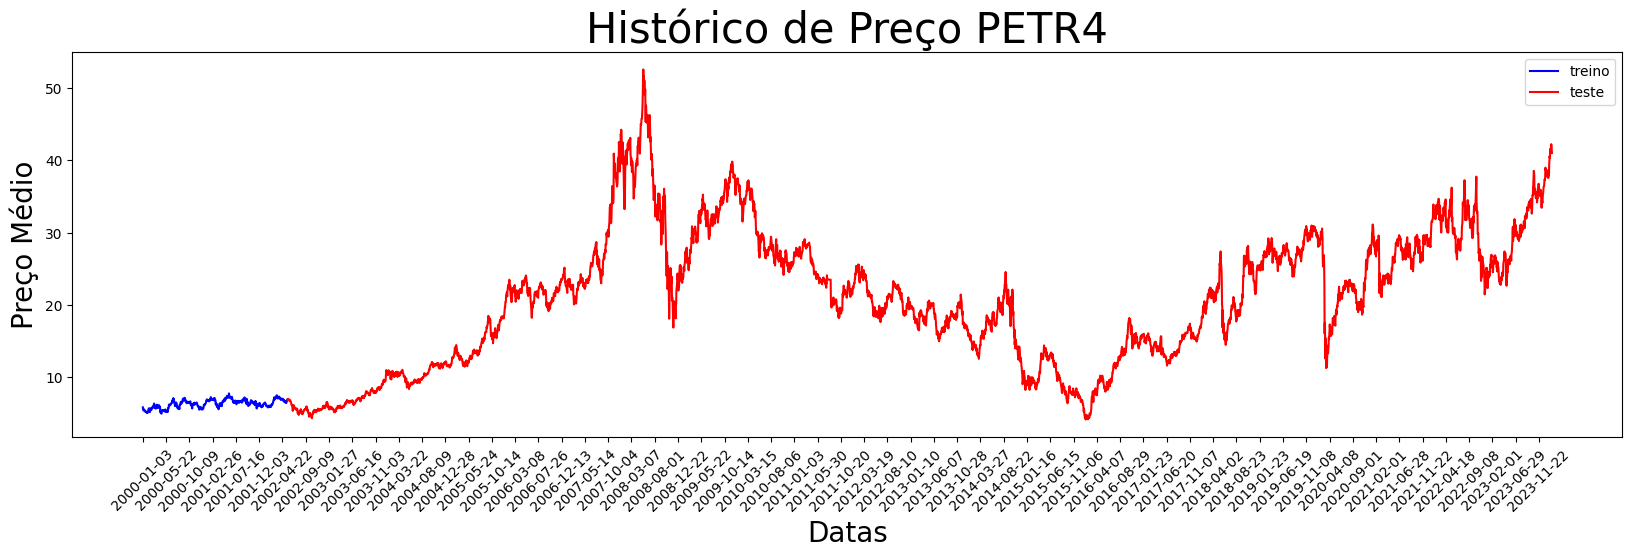

In [13]:
plt.figure(figsize = (20, 5))

plt.plot(dados['Close'].loc[0: input_data.shape[0]], color = 'blue', label = 'treino')
plt.plot(dados['Close'].loc[input_data.shape[0]: ], color = 'red', label = 'teste')
plt.xticks(range(0, dados.shape[0], 100), dados['Date'].loc[: : 100], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Médio', fontsize=20)
plt.title("Histórico de Preço PETR4", fontsize=30)

plt.legend()
plt.show()

# VISUALIZANDO DADOS TESTE

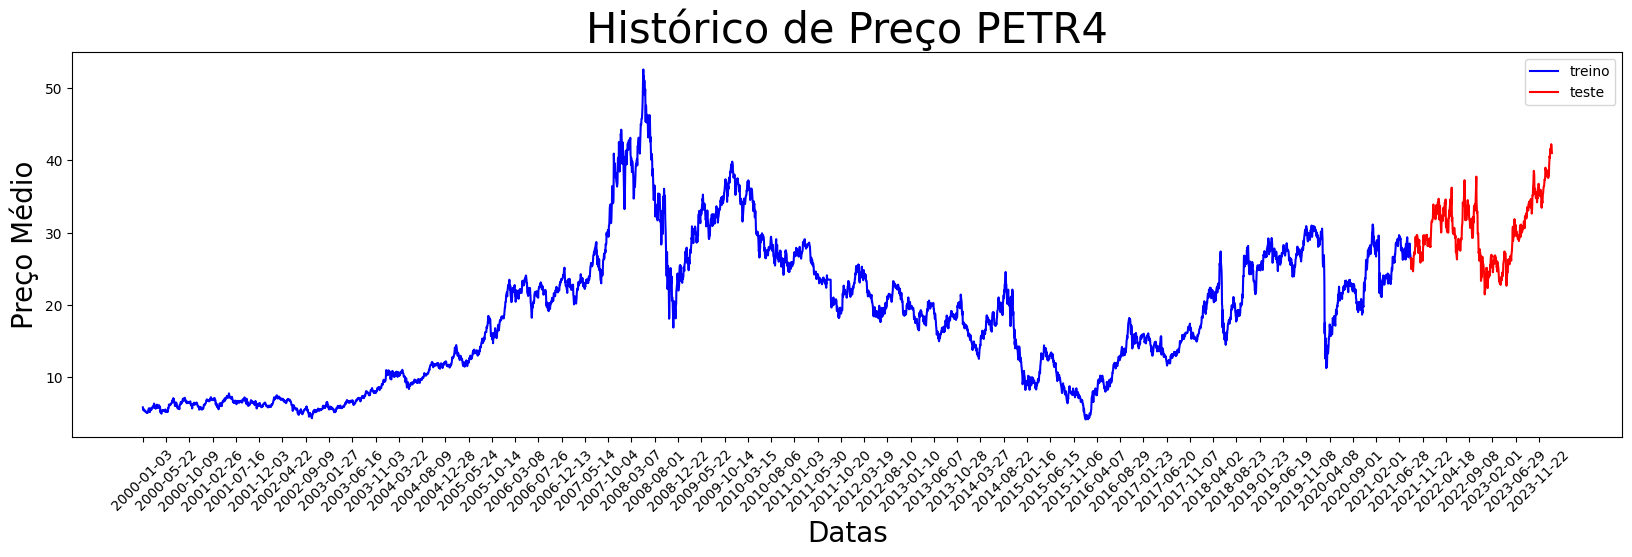

In [14]:
plt.figure(figsize = (20, 5))

plt.plot(dados['Close'].loc[0: dados_treino.shape[0]], color = 'blue', label = 'treino')
plt.plot(dados['Close'].loc[dados_treino.shape[0]: ], color = 'red', label = 'teste')
plt.xticks(range(0, dados.shape[0], 100), dados['Date'].loc[: : 100], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Médio', fontsize=20)
plt.title("Histórico de Preço PETR4", fontsize=30)

plt.legend()
plt.show()

# NORMALIZANDO DADOS

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))

dados_treino_norm = scaler.fit_transform(np.array(dados_treino).reshape(-1,1))
dados_teste_norm = scaler.transform(np.array(input_data).reshape(-1,1))
dados_validos_norm = scaler.transform(np.array(dados_teste).reshape(-1,1))

print(dados_treino_norm.shape, dados_treino_norm)

(5450, 1) [[0.03467191]
 [0.02794453]
 [0.02678535]
 ...
 [0.46367214]
 [0.45808323]
 [0.46077417]]


# GERANDO X E Y

In [16]:
#treino
X_train, y_train = [], []
for i in range(days_time_step, len(dados_treino)):
    X_train.append(dados_treino_norm[i-days_time_step:i])
    y_train.append(dados_treino_norm[i])
    
#teste
X_test = []
for i in range(days_time_step, days_time_step + len(dados_teste)):
    X_test.append(dados_teste_norm[i-days_time_step:i])
    
#val
X_val, y_val = [], []
for i in range(days_time_step, len(dados_teste)):
    X_val.append(dados_validos_norm[i-days_time_step:i])
    y_val.append(dados_validos_norm[i])

#converter tudo pra matriz numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

print(X_train.shape, X_val.shape, X_test.shape)

(5435, 15, 1) (591, 15, 1) (606, 15, 1)


# CRIANDO ARQUETETURA DA REDE NEURAL LSTM

In [34]:
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(days_time_step, 1)))
#model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False, input_shape=(days_time_step, 1)))
#model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [35]:
historico = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30
66/66 [==============================] - 3s 16ms/step - loss: 0.0143 - val_loss: 0.0019
Epoch 2/30
66/66 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/30
66/66 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/30
66/66 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 5/30
66/66 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/30
66/66 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/30
66/66 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/30
66/66 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/30
66/66 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 10/30
66/66 [==============================] - 1s 10ms/step - loss: 9.8019e-04 - val_loss: 0.0011
Epoch 11/30
6

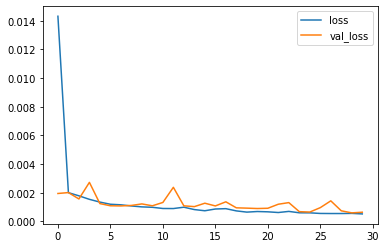

In [36]:
plt.plot(historico.history["loss"], label='loss')
plt.plot(historico.history["val_loss"], label='val_loss')
plt.legend()

# Avaliação de Resultados

In [37]:
#predição de valores pela rede
predict = model.predict(X_test)

#transformação inversa do normalizador, pra que possamos plotar no gráfico os resultados
predict = scaler.inverse_transform(predict)
real = test_data

predict.shape

(112, 1)

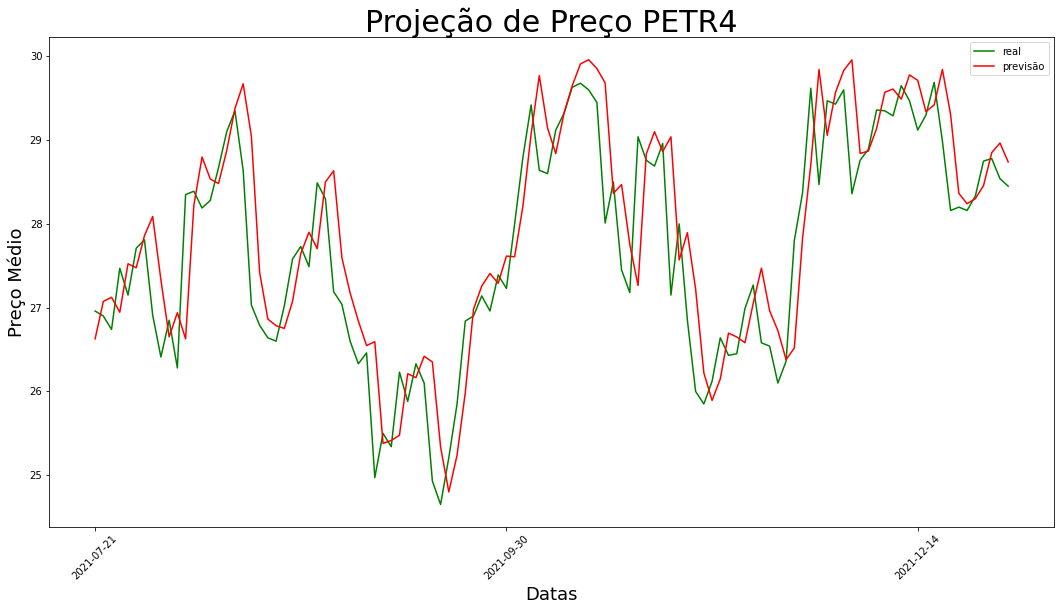

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(real, color = 'green', label = 'real')
plt.plot(predict, color = 'red', label = 'previsão')
plt.xticks(range(0, len(real), 50), df['Date'].iloc[- len(real)::50], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Projeção de Preço PETR4", fontsize=30)
plt.legend()
plt.show()

In [39]:
import math
from sklearn.metrics import mean_squared_error
mean_squared_error(real, predict)

0.4788308058056951

# Experimento 2: Estimando sem informar o conjunto de teste todo

In [40]:
X_test[0:1]

array([[[0.90861809],
        [0.90861809],
        [0.90936104],
        [0.90527485],
        [0.91196133],
        [0.92236256],
        [0.92644867],
        [0.88893009],
        [0.89598808],
        [0.91939079],
        [0.92496282],
        [0.9323922 ],
        [0.94539372],
        [0.92496282],
        [0.92310543],
        [0.92793459],
        [0.93722136],
        [0.9234769 ],
        [0.92793459],
        [0.91567604],
        [0.87184246],
        [0.88595833],
        [0.86515599],
        [0.87407129],
        [0.8803863 ],
        [0.87184246],
        [0.84992567],
        [0.83506683],
        [0.81872211],
        [0.83172359]]])

In [41]:
predicted_days = 30

X_predicted = X_test[0:1].copy() #pega o primeiro dia do conjunto de teste
future_projection = []
for d in range(predicted_days):
    #predição de valores pela rede
    next_t = model.predict(X_predicted)
    future_projection.append(next_t[0, 0])
    
    #remove primeiro preço da sequência
    temp = np.delete(X_predicted[0], 0)

    #insere último preço da sequência
    temp = np.append(temp, next_t)
    
    #recoloca no formato tensorflow
    X_predicted[0] = np.reshape(temp, (predicted_days, 1))
    
future_projection = scaler.inverse_transform(np.array(future_projection).reshape(-1, 1))

future_projection

array([[26.627796],
       [26.79308 ],
       [26.944233],
       [27.105595],
       [27.285637],
       [27.487398],
       [27.71081 ],
       [27.953785],
       [28.21333 ],
       [28.485928],
       [28.768238],
       [29.057348],
       [29.350693],
       [29.646067],
       [29.941692],
       [30.235891],
       [30.527206],
       [30.81433 ],
       [31.09622 ],
       [31.371918],
       [31.640717],
       [31.902143],
       [32.155624],
       [32.400913],
       [32.637707],
       [32.865875],
       [33.085445],
       [33.29655 ],
       [33.499367],
       [33.694138]], dtype=float32)

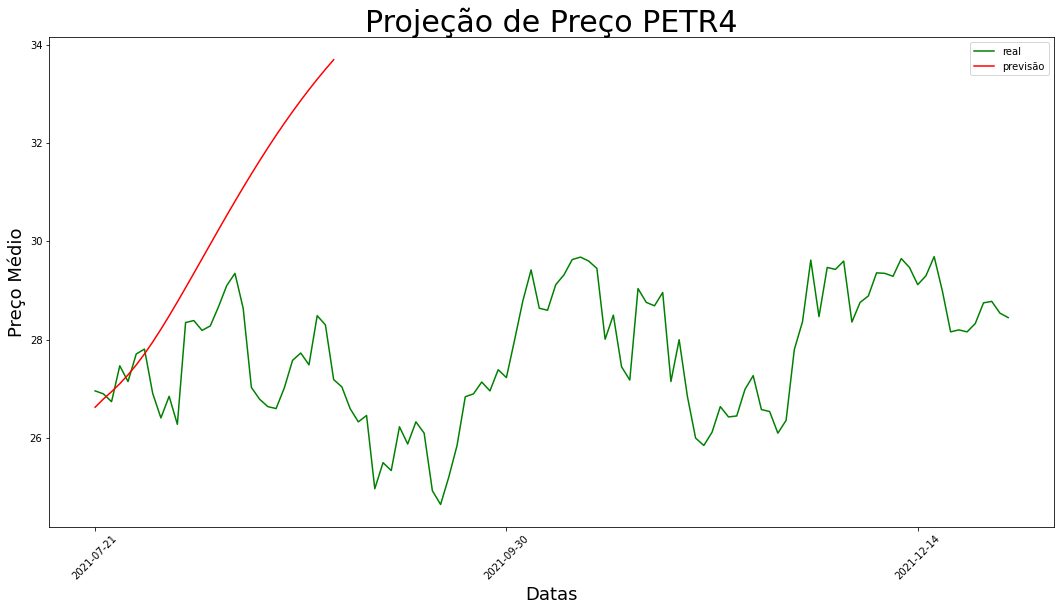

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(real, color = 'green', label = 'real')
plt.plot(future_projection, color = 'red', label = 'previsão')
plt.xticks(range(0, len(real), 50), df['Date'].iloc[- len(real)::50], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title("Projeção de Preço PETR4", fontsize=30)
plt.legend()
plt.show()

# Referências

* https://www.datacamp.com/community/tutorials/lstm-python-stock-market
* https://www.analyticsvidhya.com/blog/2021/05/stock-price-prediction-and-forecasting-using-stacked-lstm/#:~:text=LSTMs%20are%20widely%20used%20for,the%20information%20that%20is%20not.
* https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/
* https://medium.com/alexandre-george-lustosa/previs%C3%A3o-de-pre%C3%A7o-petr4-com-python-lstm-f93722be59e0
* https://finance.yahoo.com/quote/PETR4.SA/history?period1=1356998400&period2=1640995200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
* http://revistagt.fpl.edu.br/get/article/view/1930/1230